# Защита персональных данных клиентов

Необходимо защитить данные клиентов страховой компании, разработав такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию и обосновав корректность его работы.
Необходимо, чтобы при преобразовании качество моделей машинного обучения не ухудшилось.

## 1.  Загрузка данных

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [2]:
df = pd.read_csv('datasets/insurance.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


Датасет содержит 5 колонок и 5000 столбцов. Тип данных - числовой (float, int).
<br>Преобразуем возраст и зарплату в целочисленные значения.

In [4]:
df['Возраст'].astype('int')
df['Зарплата'].astype('int')

0       49600
1       38000
2       21000
3       41700
4       26100
        ...  
4995    35700
4996    52400
4997    33900
4998    32700
4999    40600
Name: Зарплата, Length: 5000, dtype: int32

In [5]:
df.head()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


In [6]:
# Проверим значения столбцов.

for col in df.columns:
    print('Пропусков в колонке', col, df[col].isna().sum())
    if col != 'Зарплата' and col != 'Возраст':
        print(df[col].value_counts(), '\n')

print('Дубликатов строк:', df.duplicated().sum())

Пропусков в колонке Пол 0
0    2505
1    2495
Name: Пол, dtype: int64 

Пропусков в колонке Возраст 0
Пропусков в колонке Зарплата 0
Пропусков в колонке Члены семьи 0
1    1814
0    1513
2    1071
3     439
4     124
5      32
6       7
Name: Члены семьи, dtype: int64 

Пропусков в колонке Страховые выплаты 0
0    4436
1     423
2     115
3      18
4       7
5       1
Name: Страховые выплаты, dtype: int64 

Дубликатов строк: 153


Пропущенных значений нет.
<br>Выявлено 153 дубликата строк, что нормально для таких дискретных значений.

In [7]:
def boxplot_values(item):
    upper_quartile = df[item].quantile(0.75)
    lower_quartile = df[item].quantile(0.25)
    median = df[item].median()
    mean = df[item].mean()
    iqr = upper_quartile - lower_quartile
    upper_whisker = df[item][df[item] <= upper_quartile + 1.5 * iqr].max()
    lower_whisker = df[item][df[item] >= lower_quartile - 1.5 * iqr].min()
    print('25-й процентиль:', lower_quartile)
    print('75-й процентиль:', upper_quartile)
    print('Медиана: ', median)
    print('Среднее: ', mean)
    print('Нижний ус:', lower_whisker)
    print('Верхний ус:', upper_whisker)

def hist_boxplot(item):
    df[item].hist(bins=200, figsize=(15, 5)).set(xlabel=item, ylabel='Частота');
    plt.show()
    df.boxplot(column=item, vert=False, figsize=(15,3)).set(xlabel='Частота');
    boxplot_values(item)

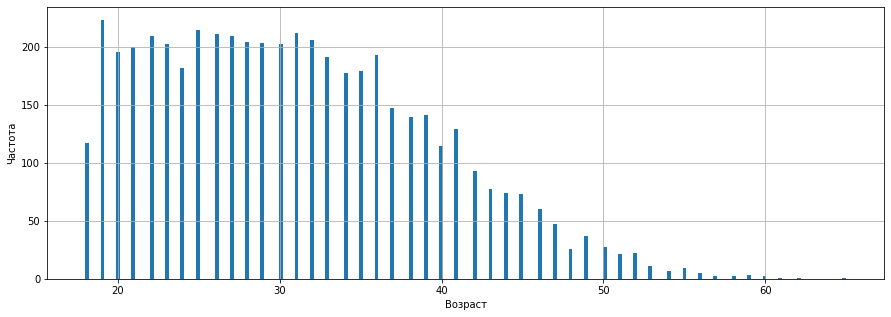

25-й процентиль: 24.0
75-й процентиль: 37.0
Медиана:  30.0
Среднее:  30.9528
Нижний ус: 18.0
Верхний ус: 56.0


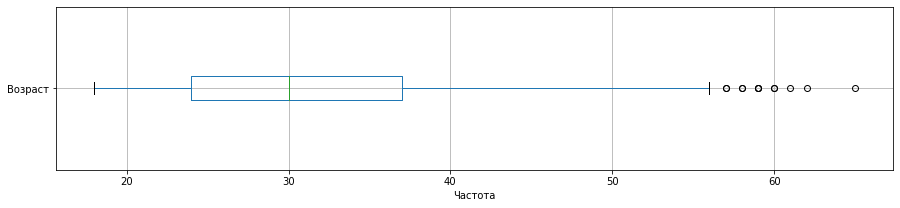

In [8]:
hist_boxplot('Возраст')

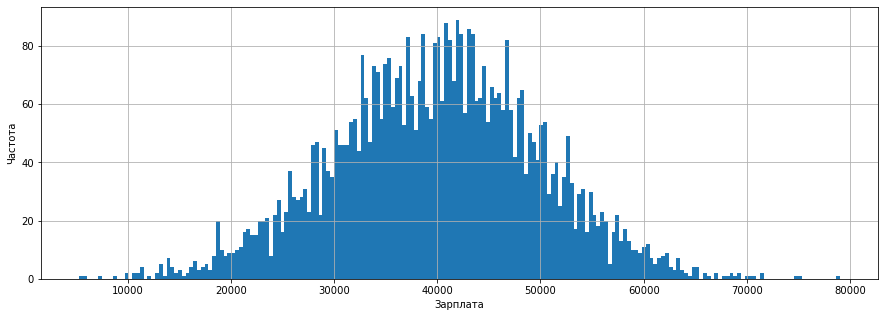

25-й процентиль: 33300.0
75-й процентиль: 46600.0
Медиана:  40200.0
Среднее:  39916.36
Нижний ус: 13400.0
Верхний ус: 66300.0


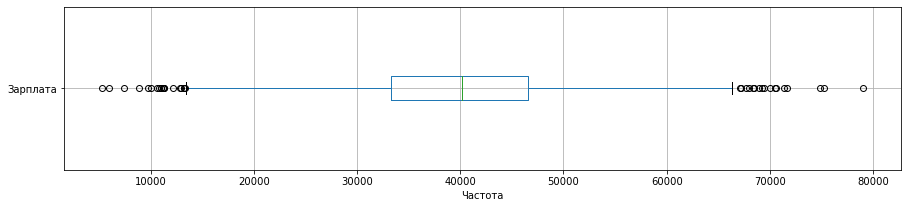

In [9]:
hist_boxplot('Зарплата')

Распределение возраста - пуассоновское, распределение зарплат - нормальное. Аномалий не выявлено.

Данные получены, проверены и предобработанны (изменен тип столбцов возраста и зарплаты с float на int)

## 2.  Умножение матриц

Качество линейной регрессии не изменится при умножении призаков на обратимую матрицу.

**Обоснование:**

1. Пусть $P$ это обратимая матрица, обратная матрице признаков $X$.
<br>

2. Тогда формула предсказаний имеет вид:
$$
a' = XPw'
$$
<br>

а формула обучения:
$$
w' = ((XP)^T(XP))^{-1}(XP)^Ty
$$
<br>

3. Поскольку, $(AB)^T = B^TA^T$, преобразуем формулу обучения:
$$
w' = (P^T(X^TX)P)^{-1}P^TX^Ty
$$
<br>

4. Поскольку $(AB)^{-1} = B^{-1}A^{-1}$, преобразуем формулу обучения:
$$
w' = P^{-1}(X^TX)^{-1}(P^T)^{-1}P^TX^Ty
$$
<br>

5. Так как в получившемся выражении одно из произведений множителей дает единичную матрицу $(P^T)^{-1}P^T = E$, сократим его:
$$
w' = P^{-1}(X^TX)^{-1}EX^Ty = P^{-1}(X^TX)^{-1}X^Ty = P^{-1}w
$$
<br>

6. При этом, значения предсказаний на признаках обратной матрицы:
$$
a' = XPw' = XPP^{-1}w = XEw = Xw = a
$$

Таким образом, при домножении признаков линейной регрессии на обратимую матрицу ее предсказания остаются неизменными, а качество модели не ухудшается.

## 3.  Алгоритм преобразования

**Алгоритм**

- Создадать случайную матрицу принзнаков модели размерность которой равна числу признаков датасета (4x4).
- Умножить случайную матрицу на признаки.
- Найти R2 обученной модели на исходных признаках.
- Найти R2 обученной модели на преобразованных признаках.
- Сравнить R2 обеих моделей.

**Обоснование**

Матрица, обратная той, на которую будут домножаться признаки датасета, станет "ключом", без которой невозможно восстановить исходные данные.

## 4.  Проверка алгоритма

Закодируем признаки.

In [10]:
# Выделим признаки и целевой признак.

features = df.drop('Страховые выплаты', axis=1)
target = df['Страховые выплаты']

In [11]:
# Создадим матрицу размерностью 4x4 из случайных числел.

r = np.random.RandomState(42)
matrix = r.normal(size = (4,4))

matrix = np.linalg.inv(matrix)

In [12]:
# Умножим матрицу на признаки.

features_trans = features @ matrix

Построим модель на исходных признаках датасета и вычислим R2.

In [13]:
model = LinearRegression()
model.fit(features, target)
normal_predictions = model.predict(features)
r2_score_normal = r2_score(target, normal_predictions)
print('R2 на исходных признаках:', r2_score_normal)

R2 на исходных признаках: 0.4249455028666801


Построим модель на преобразованных признаках датасета и вычислим R2.

In [14]:
model.fit(features_trans, target)
transform_predictions = model.predict(features_trans)
r2_score_trans = r2_score(target, transform_predictions)
print('R2 на преобразованных признаках:', r2_score_trans)

R2 на преобразованных признаках: 0.42494550286668875


## 5. Итоги исследования

Разность R2 моделей находится на незначитеьном уровне, следовательно, качество обученной модели после преобразования признаков такое же как и при обучении без преобразования признаков.